In [1]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import geopandas as gpd
import plotly.graph_objects as go

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load Data

In [5]:
df= pd.read_csv('http://covidtracking.com/api/states/daily.csv')
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200404,AK,171.0,5869.0,NaN,NaN,16.0,NaN,NaN,NaN,...,16.0,6040,6040,6040,2,2.0,1.0,10.0,14.0,24.0
1,20200404,AK,171.0,5869.0,NaN,NaN,16.0,NaN,NaN,NaN,...,16.0,6040,6040,6040,2,0.0,0.0,0.0,0.0,0.0
2,20200404,AL,1580.0,9273.0,NaN,NaN,212.0,NaN,NaN,NaN,...,212.0,10853,10853,10853,1,8.0,212.0,1086.0,148.0,1234.0
3,20200404,AL,1580.0,9273.0,NaN,NaN,212.0,NaN,NaN,NaN,...,212.0,10853,10853,10853,1,0.0,0.0,0.0,0.0,0.0
4,20200404,AR,743.0,9627.0,NaN,72.0,NaN,NaN,NaN,23.0,...,NaN,10370,10370,10370,5,2.0,0.0,632.0,39.0,671.0


# Overview by State

In [3]:
def latest_by_state(df, action_index= 0):
    df_latest= slice_latest(df)
    plot_by_state(df_latest, action_index)

In [4]:
def slice_latest(df):
    df_latest= df.head(56).copy()
    df_latest['total_pos_rate']= df_latest['positive']/df_latest['total']*100
    df_latest['daily_pos_rate']= df_latest['positiveIncrease']/df_latest['totalTestResultsIncrease']*100
    df_latest['date']= pd.to_datetime(df_latest['dateChecked'].str.slice(0, 10, 1), format= '%Y-%m-%d')
    df_latest.at[27, 'total_pos_rate']= 0
    df_latest['positive']= df_latest['positive'].round(0).astype(int)
    
    return df_latest

In [5]:
def plot_by_state(df, action_index):
    # If action_id == 0, plot test positive rate by state
    # If action_id == 1, plot positive cases by state
    
    data= {'variable': ['total_pos_rate', 'positive'],
           'plot_title': ['Total Test Positive Rate', 'Total Positive Cases'],
           'legend': ['Test Positive Rate (%)', 'Positive Cases']}
    action= pd.DataFrame(data, columns= ['variable', 'plot_title', 'legend'])
    
    for col in df.columns:
        df[col] = df[col].astype(str)

    if action_index == 0:
        df['text']= 'Total positive cases: ' + df['positive'] + '<br>' + 'Total test results: ' + df['totalTestResults']
    if action_index == 1:
        df['text']= 'Total death: ' + df['death']
        
    fig = go.Figure(data= go.Choropleth(
        locations= df['state'], # Spatial coordinates
        z= df[action['variable'][action_index]].astype(float), # Data to be color-coded
        locationmode= 'USA-states', # set of locations match entries in `locations`
        colorscale= 'Reds',
        text= df['text'], # hover text
        marker_line_color= 'white',
        colorbar_title= action['legend'][action_index],
    ))

    fig.update_layout(
        title_text = 'COVID-19 %s by State (updated on %s)' % (action['plot_title'][action_index], df['date'][0]),
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()

# Test Positive Rate Trend by State

In [6]:
def state_pos_rate(df, state):
    df_state= slice_state(df, state)
    plot_test_pos_rate(df_state, state)

In [7]:
def slice_state(df, state):
    df_state= df.loc[df['state'] == state].copy()
    df_state['total_pos_rate']= df_state['positive']/df_state['total']*100
    df_state['daily_pos_rate']= df_state['positiveIncrease']/df_state['totalTestResultsIncrease']*100
    df_state['date']= pd.to_datetime(df_state['dateChecked'].str.slice(0, 10, 1), format= '%Y-%m-%d')
    
    return df_state

In [8]:
def plot_test_pos_rate(df, state):
    sns.reset_orig()
    date_form= mdates.DateFormatter("%m-%d")
    markers_on= [0, 1, 2] 
    weekday= SU
    
    fig0, ax0= plt.subplots(figsize=(8.4, 5))
    plt.plot(df['date'], df['total_pos_rate'], color= 'tab:blue', marker= 'o', markevery= markers_on)
    ax0.fmt_xdata = date_form # mdates.DateFormatter('%m-%d')
    ax0.grid()
    ax0.set(ylabel= 'Cumulative Test Positive Rate (%)',
           title= state + ' State COVID-19 Test Positive Rate')
    fig0.autofmt_xdate()    
    ax0.xaxis.set_major_formatter(date_form)
    ax0.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday))
    
    
    fig1, ax1= plt.subplots(figsize=(8, 5))
    color= 'tab:red'
    ax1.set(xlabel= 'Date')
    ax1.set_ylabel('Daily Test Positive Rate (%)', color= color)
    ax1.plot(df['date'], df['daily_pos_rate'], color= color, marker= 'o', markevery= markers_on)
    ax1.tick_params(axis= 'y', labelcolor= color)   

    ax2= ax1.twinx()  
    color= 'tab:green'
    ax2.set_ylabel('Daily Test Volume', color= color)  
    ax2.plot(df['date'], df['totalTestResultsIncrease'], color= color, marker= 'o', markevery= markers_on)
    ax2.tick_params(axis='y', labelcolor= color)
    fig1.autofmt_xdate()    
    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= weekday)) 

    fig1.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.show()
    

# User Interface

In [9]:
latest_by_state(df)

ValueError: Cannot convert non-finite values (NA or inf) to integer

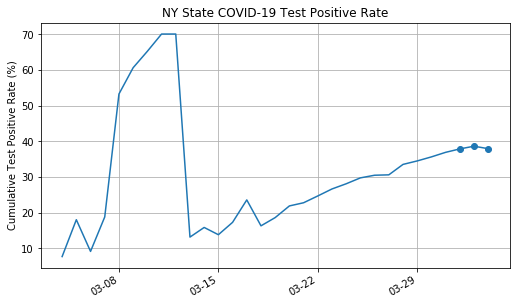

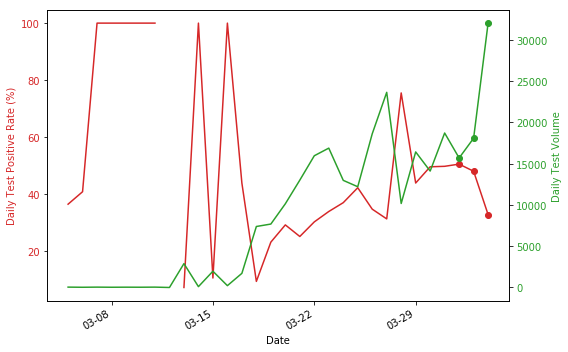

In [10]:
state_pos_rate(df, 'NY')

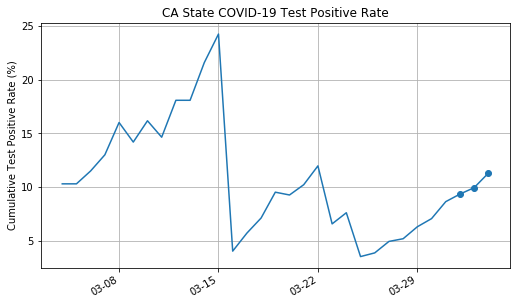

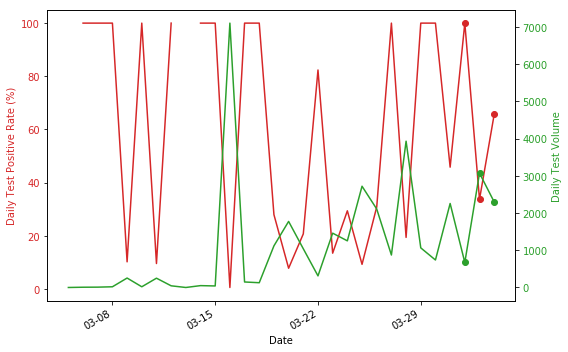

In [12]:
state_pos_rate(df, 'CA')